In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


Mounted at /content/gdrive


# 1. Introduce the datasets

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/DSO 579 Sports Analytics/Injuries.csv')
df.head()

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


In [ ]:
df[df['Notes'] == 'placed on IL']

,Date,Team,Acquired,Relinquished,Notes
16,2010-10-26,Blazers,NaN,Elliot Williams,placed on IL
21,2010-10-26,Celtics,NaN,Luke Harangody,placed on IL
22,2010-10-26,Heat,NaN,Dexter Pittman,placed on IL
23,2010-10-26,Heat,NaN,Jerry Stackhouse,placed on IL
28,2010-10-26,Rockets,NaN,Jermaine Taylor,placed on IL
...,...,...,...,...,...
26644,2020-03-06,Heat,NaN,Gabe Vincent,placed on IL
26668,2020-03-07,Nuggets,NaN,Vlatko Cancar,placed on IL
26825,2020-08-01,Heat,NaN,Gabe Vincent,placed on IL
26884,2020-08-07,Pelicans,NaN,Zion Williamson,placed on IL


In [ ]:
df = df[df['Notes'] != 'placed on IL']
df = df[df['Notes'] != 'activated from IL']
df = df[df['Notes'] != 'returned to lineup']

#This takes out all Notes that have people returning from the inactive list, but also removes "placed on IL"

In [ ]:
df['Out Indefinitely'] = df['Notes'].str.contains('out indefinitely') | df['Notes'].str.contains('out for season')

In [ ]:
df[df['Notes'] =='placed on IL with sprained left ankle']

,Date,Team,Acquired,Relinquished,Notes,Out Indefinitely
37,2010-10-27,Bobcats,NaN,Kwame Brown,placed on IL with sprained left ankle,False
60,2010-10-27,Knicks,NaN,Anthony Randolph,placed on IL with sprained left ankle,False
198,2010-11-06,Magic,NaN,Jameer Nelson,placed on IL with sprained left ankle,False
212,2010-11-07,Rockets,NaN,Aaron Brooks,placed on IL with sprained left ankle,False
214,2010-11-07,Thunder,NaN,Jeff Green,placed on IL with sprained left ankle,False
...,...,...,...,...,...,...
26691,2020-03-08,Timberwolves,NaN,Kelan Martin,placed on IL with sprained left ankle,False
26809,2020-07-31,Rockets,NaN,Eric Gordon,placed on IL with sprained left ankle,False
26848,2020-08-04,Jazz,NaN,Nigel Williams-Goss,placed on IL with sprained left ankle,False
26869,2020-08-06,Heat,NaN,Goran Dragic,placed on IL with sprained left ankle,False


In [ ]:
# something we can add: adductor, bronchitis,chest,nose,forearm,gluteus,eye,heel,patella,quadricap,rib,shin,
# thigh,tibia,toe,pelvis,kneecap,leg,orbital bone,thumb,spinal cord,tailbone,cervical,corneal abrasion,cheekbone,collarbone,jaw,flexor,forehead,fibula,oral,facial,abdominal,heart,throat
injuries = ['knee', 'shoulder', 'hip', 'ankle', 'elbow', 'foot', 'heel', 'hand', 'hamstring', 'back', 'groin', 'neck', 'head', 'wrist', 'calf', 'leg', 'concussion', 'Achilles',
            'thigh', 'tibia', 'toe', 'adductor', 'chest', 'nose', 'forearm', 'gluteus', 'eye', 'patella', 'quadricap','rib','shin','pelvis','kneecap','orbital','thumb',
            'spinal cord', 'tailbone','cervical','cornea','cheekbone','collarbone','jaw','flexor','forehead','fibula','oral','facial','abdominal','abdomen','heart','throat', 'quadricep', 'oblique', 'finger', 'hernia'
            , 'abductor', 'tricep', 'bicep', 'lat', 'lung', 'face','biceps','triceps','pectoral','plantar','disc']

def injury_detection(x):
  matching_injury = []
  for injury in injuries:
    if injury in x:
      matching_injury.append(injury)
  if len(matching_injury) == 1:
    return matching_injury[0]
  elif len(matching_injury) > 1:
    return ' and '.join(matching_injury)
  elif len(matching_injury) == 0:
    return 'other'

In [ ]:
df['injury_type'] = df['Notes'].apply(injury_detection)

In [ ]:
df['injury_type'].value_counts()

knee                                       2499
other                                      2201
ankle                                      2118
back                                        922
hamstring                                   636
                                           ... 
shoulder and ankle                            1
foot and hamstring                            1
back and wrist                                1
neck and concussion and hernia and disc       1
shoulder and neck                             1
Name: injury_type, Length: 182, dtype: int64

In [ ]:
def categorize_injury(injury):
    if injury in ['hand', 'wrist', 'thumb', 'finger']:
        return 'Hand'
    elif injury in ['facial', 'jaw', 'cheekbone', 'orbital', 'nose', 'eye', 'oral', 'cornea', 'forehead','throat','face']:
        return 'Facial'
    elif injury in ['back', 'spinal cord', 'tailbone']:
        return 'Back'
    elif injury in ['leg', 'thigh', 'tibia', 'shin', 'quadricep', 'hamstring', 'knee','patella', 'kneecap', 'calf','Achilles','adductor','fibula', 'ankle']:
        return 'Leg'
    elif injury in ['plantar','foot', 'heel', 'toe']:
        return 'Foot'
    elif injury in ['forearm','elbow', 'arm','tricep','bicep','biceps','triceps','flexor']:
        return 'Arm'
    elif injury in ['shoulder', 'chest', 'collarbone', 'rib','abdominal', 'abdomen', 'heart', 'lung', 'pectoral','disc']:
        return 'Upper Body'
    elif injury in ['hip', 'groin', 'pelvis', 'gluteus','quadricap']:
        return 'Lower Body'
    elif injury in ['head','concussion', 'neck','cervical']:
        return 'Head'
    else:
        return 'Others'

# Apply the categorize_injury function to create a new column
df['body_part'] = df['injury_type'].apply(categorize_injury)


In [ ]:
#Converting Date column to Date time
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
#Basically, this checks each datetime, and if it's between two dates, returns the season number. I looked up each season's dates online. It took forever tbh
def categorize_season(date):
    if pd.Timestamp('2010-10-26') <= date <= pd.Timestamp('2011-12-24'):
        return '10-11'
    elif pd.Timestamp('2011-12-25') <= date <= pd.Timestamp('2012-10-29'):
        return '11-12'
    elif pd.Timestamp('2012-10-30') <= date <= pd.Timestamp('2013-10-28'):
        return '12-13'
    elif pd.Timestamp('2013-10-29') <= date <= pd.Timestamp('2014-10-27'):
        return '13-14'
    elif pd.Timestamp('2014-10-28') <= date <= pd.Timestamp('2015-10-26'):
        return '14-15'
    elif pd.Timestamp('2015-10-27') <= date <= pd.Timestamp('2016-10-24'):
        return '15-16'
    elif pd.Timestamp('2016-10-24') <= date <= pd.Timestamp('2017-10-16'):
        return '16-17'
    elif pd.Timestamp('2017-10-17') <= date <= pd.Timestamp('2018-10-15'):
        return '17-18'
    elif pd.Timestamp('2018-10-16') <= date <= pd.Timestamp('2019-10-21'):
        return '18-19'
    elif pd.Timestamp('2019-10-22') <= date <= pd.Timestamp('2020-12-21'):
        return '19-20'
    elif pd.Timestamp('2020-12-22') <= date <= pd.Timestamp('2021-10-18'):
        return '20-21'

In [ ]:
df['SEASON'] = df['Date'].apply(categorize_season)

In [ ]:
# filter injuries_only dataset to be 2013-2020 and get ready to merge with the in-game stats data

df = df[df['SEASON'].notna()]
df = df[~df['SEASON'].isin(['10-11', '11-12', '12-13'])]

In [ ]:
df_injuries_only = df.copy()

In [ ]:
df_injuries_only

,Date,Team,Acquired,Relinquished,Notes,Out Indefinitely,injury_type,body_part,SEASON
7514,2013-10-29,76ers,NaN,Jason Richardson,placed on IL recovering from surgery on left k...,True,knee,Leg,13-14
7515,2013-10-29,76ers,NaN,Nerlens Noel,placed on IL recovering from surgery on left k...,True,knee,Leg,13-14
7516,2013-10-29,Bucks,NaN,Carlos Delfino,recovering from surgery on right foot (out ind...,True,foot,Foot,13-14
7517,2013-10-29,Cavaliers,NaN,Carrick Felix,sports hernia (out indefinitely),True,hernia,Others,13-14
7518,2013-10-29,Celtics,NaN,Rajon Rondo,recovering from surgery on left knee to repair...,True,knee,Leg,13-14
...,...,...,...,...,...,...,...,...,...
27097,2020-09-22,Celtics,NaN,Romeo Langford,surgery on right wrist (out for season),True,wrist,Hand,19-20
27098,2020-09-23,Heat,NaN,Gabe Vincent,sore right knee (DTD),False,knee,Leg,19-20
27099,2020-09-30,Heat,NaN,Bam Adebayo,strained left shoulder (DTD),False,shoulder,Upper Body,19-20
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD),False,neck,Head,19-20


In [ ]:
## upload the second dataset to google colab (player in-game stats)
df_gamestats = pd.read_csv('/content/gdrive/MyDrive/DSO 579 Sports Analytics/merged.csv')

In [ ]:
df_gamestats = df_gamestats[~df_gamestats['SEASON'].isin(['20-21', '21-22', '22-23', '23-24'])]

In [ ]:
# we have ~500 players per season, so total 3727 from 2013-2020
df_gamestats

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_SEC_PER_TOUCH,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE
1851,203932,Aaron Gordon,19-20,19.5,24.0,80,235,62,32.5,0.205,...,2.88,1.91,1.8,3.2,4.3,NaN,NaN,NaN,NaN,NaN
1852,1628988,Aaron Holiday,19-20,19.5,23.0,72,185,66,24.5,0.182,...,4.35,4.17,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN
1853,1627846,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,0.164,...,2.05,1.41,0.2,0.0,0.4,Thunder,2020-01-15,2020-01-29,14.0,Sprained_ankle
1854,1629690,Adam Mokoka,19-20,19.5,21.0,77,190,11,10.2,0.110,...,1.47,0.83,0.2,0.0,0.8,NaN,NaN,NaN,NaN,NaN
1855,1629678,Admiral Schofield,19-20,19.5,23.0,77,241,33,11.2,0.118,...,1.40,0.51,0.2,0.2,0.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,2584,Willie Green,13-14,13.5,32.0,75,201,55,15.8,0.162,...,2.44,1.84,0.5,0.1,0.5,NaN,NaN,NaN,NaN,NaN
5574,201163,Wilson Chandler,13-14,13.5,27.0,80,225,62,31.1,0.193,...,2.33,1.26,1.4,1.0,1.7,NaN,NaN,NaN,NaN,NaN
5575,202333,Xavier Henry,13-14,13.5,23.0,78,220,43,21.1,0.223,...,3.24,2.45,0.9,0.1,1.2,NaN,NaN,NaN,NaN,NaN
5576,2216,Zach Randolph,13-14,13.5,32.0,81,260,79,34.2,0.258,...,2.15,0.81,3.6,17.3,9.5,NaN,NaN,NaN,NaN,NaN


In [ ]:
# We merged the datasets by left join the player in-game stats table
# using player names, seasons, and teams as unique keys
merged_df = pd.merge(df_gamestats, df_injuries_only, how = 'left', left_on=['PLAYER_NAME', 'SEASON', 'TEAM'], right_on=['Relinquished', 'SEASON', 'Team'])

In [ ]:
# Clean the merged_df by dropping duplicated entry
merged_df_cleaned = merged_df.drop_duplicates(subset = ['SEASON_NUM', 'injury_type', 'Out Indefinitely', 'PLAYER_NAME', 'Team'])
merged_df_cleaned

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,DAYS MISSED,INJURED_TYPE,Date,Team,Acquired,Relinquished,Notes,Out Indefinitely,injury_type,body_part
0,203932,Aaron Gordon,19-20,19.5,24.0,80,235,62,32.5,0.205,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1628988,Aaron Holiday,19-20,19.5,23.0,72,185,66,24.5,0.182,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1627846,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,0.164,...,14.0,Sprained_ankle,2020-01-14,Thunder,NaN,Abdel Nader,sprained left ankle (DTD),False,ankle,Leg
4,1627846,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,0.164,...,14.0,Sprained_ankle,2020-08-14,Thunder,NaN,Abdel Nader,placed on IL with neck injury,False,neck,Head
5,1629690,Adam Mokoka,19-20,19.5,21.0,77,190,11,10.2,0.110,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142,2584,Willie Green,13-14,13.5,32.0,75,201,55,15.8,0.162,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6143,201163,Wilson Chandler,13-14,13.5,27.0,80,225,62,31.1,0.193,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6144,202333,Xavier Henry,13-14,13.5,23.0,78,220,43,21.1,0.223,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6145,2216,Zach Randolph,13-14,13.5,32.0,81,260,79,34.2,0.258,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
clean_list = ['PLAYER_ID', 'Acquired', 'Relinquished']
merged_df_cleaned = merged_df_cleaned.drop(columns = clean_list, index = 1)

In [ ]:
merged_df_cleaned.columns

Index(['PLAYER_NAME', 'SEASON', 'SEASON_NUM', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'GP', 'MIN', 'USG_PCT', 'PACE', 'POSS', 'FGA_PG',
       'DRIVES', 'DRIVE_FGA', 'DRIVE_PASSES', 'DIST_MILES', 'AVG_SPEED',
       'PULL_UP_FGA', 'PULL_UP_FG3A', 'TOUCHES', 'FRONT_CT_TOUCHES',
       'AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH', 'ELBOW_TOUCHES',
       'POST_TOUCHES', 'PAINT_TOUCHES', 'TEAM', 'INJURED ON', 'RETURNED',
       'DAYS MISSED', 'INJURED_TYPE', 'Date', 'Team', 'Notes',
       'Out Indefinitely', 'injury_type', 'body_part'],
      dtype='object')

In [ ]:
merged_df_cleaned.shape

(4274, 37)

***Now we have our final dataset with 4274 Observations and 37 columns***

## Further Data Processing

In [ ]:
# Out Indefinitely Dummy
merged_df_cleaned['Out Indefinitely'].fillna(False, inplace=True)
merged_df_cleaned['Out Indefinitely'] = [1 if x == True else 0 for x in merged_df_cleaned['Out Indefinitely']]

In [ ]:
merged_df_cleaned['Injured'] = np.where(merged_df_cleaned['injury_type'].notna(), 1, 0)

In [ ]:
merged_df_cleaned

,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,PACE,...,RETURNED,DAYS MISSED,INJURED_TYPE,Date,Team,Notes,Out Indefinitely,injury_type,body_part,Injured
0,Aaron Gordon,19-20,19.5,24.0,80,235,62,32.5,0.205,99.72,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0
2,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,0.164,101.79,...,2020-01-29,14.0,Sprained_ankle,2020-01-14,Thunder,sprained left ankle (DTD),0,ankle,Leg,1
4,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,0.164,101.79,...,2020-01-29,14.0,Sprained_ankle,2020-08-14,Thunder,placed on IL with neck injury,0,neck,Head,1
5,Adam Mokoka,19-20,19.5,21.0,77,190,11,10.2,0.110,100.37,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0
6,Admiral Schofield,19-20,19.5,23.0,77,241,33,11.2,0.118,103.13,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142,Willie Green,13-14,13.5,32.0,75,201,55,15.8,0.162,98.46,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0
6143,Wilson Chandler,13-14,13.5,27.0,80,225,62,31.1,0.193,99.49,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0
6144,Xavier Henry,13-14,13.5,23.0,78,220,43,21.1,0.223,101.48,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0
6145,Zach Randolph,13-14,13.5,32.0,81,260,79,34.2,0.258,90.59,...,NaN,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN,0


In [ ]:
merged_df_cleaned.dtypes[merged_df_cleaned.dtypes == object]

PLAYER_NAME             object
SEASON                  object
PLAYER_HEIGHT_INCHES    object
PLAYER_WEIGHT           object
DIST_MILES              object
AVG_SPEED               object
PULL_UP_FG3A            object
TEAM                    object
INJURED ON              object
RETURNED                object
INJURED_TYPE            object
Team                    object
Notes                   object
injury_type             object
body_part               object
dtype: object

**Data Processing**

In [ ]:
# Extracting the year and month from the 'date' column
merged_df_cleaned['year'] = pd.DatetimeIndex(merged_df_cleaned['Date']).year
merged_df_cleaned['month'] = pd.DatetimeIndex(merged_df_cleaned['Date']).month

In [ ]:
# Turn columns into numerical
numeric_columns = ['PLAYER_HEIGHT_INCHES', 'GP', 'PLAYER_WEIGHT', 'POSS', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FG3A']
for col in numeric_columns:
  merged_df_cleaned[col] = pd.to_numeric(merged_df_cleaned[col], errors='coerce')

# 2. Data Visualization


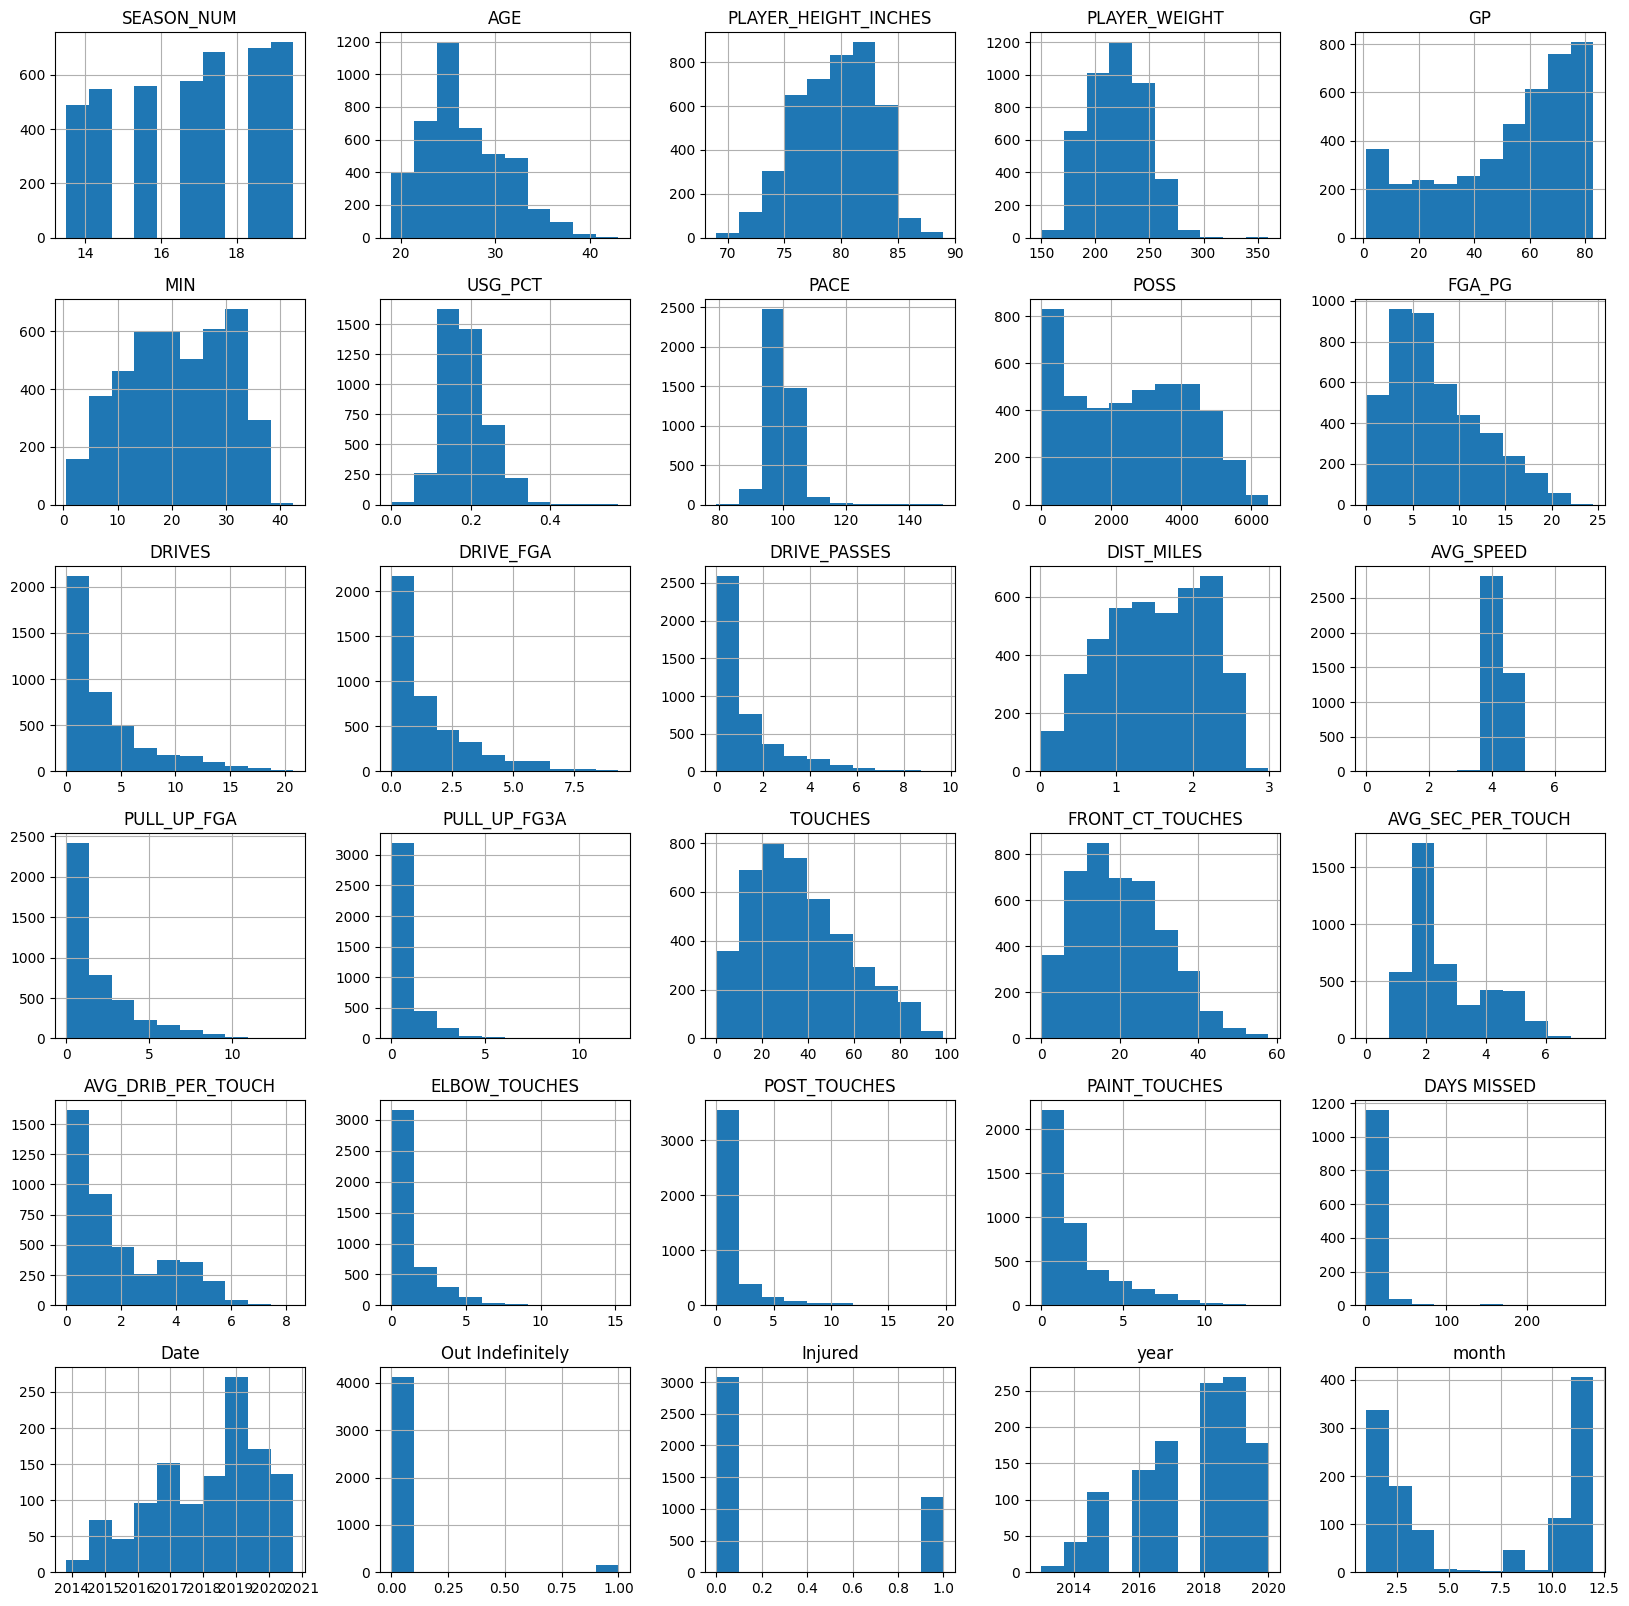

In [ ]:
merged_df_cleaned.hist(figsize = (20,20))
plt.show()

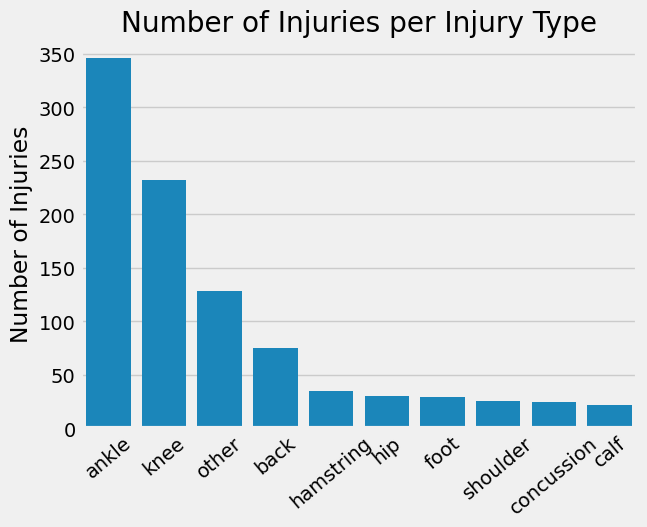

In [ ]:
plt.style.use('fivethirtyeight')
sns.barplot(merged_df_cleaned['injury_type'].value_counts().head(10))
plt.xticks(rotation = 40)
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries per Injury Type')
plt.show()
#We can see here that the most common injuries appear to be ankle and knee related
#Other category includes inactive list injuries that were not listed, or were out due to non-play related injuries, such as stomach flu, Covid, or other illness

In [ ]:
merged_df_cleaned['lower body injury'] = np.where(merged_df_cleaned['body_part'] == 'Lower Body', 1, 0)

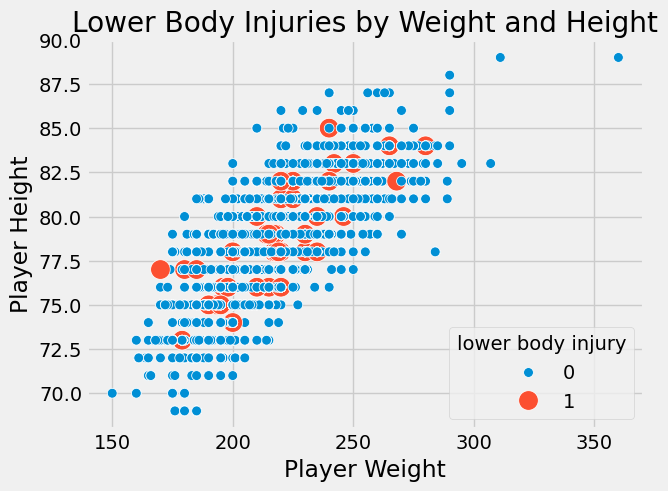

In [ ]:
sns.scatterplot(x='PLAYER_WEIGHT', y='PLAYER_HEIGHT_INCHES', hue='lower body injury', data=merged_df_cleaned, size='lower body injury', sizes=(200, 50))
plt.ylabel('Player Height')
plt.xlabel('Player Weight')
plt.title('Lower Body Injuries by Weight and Height')
plt.show()

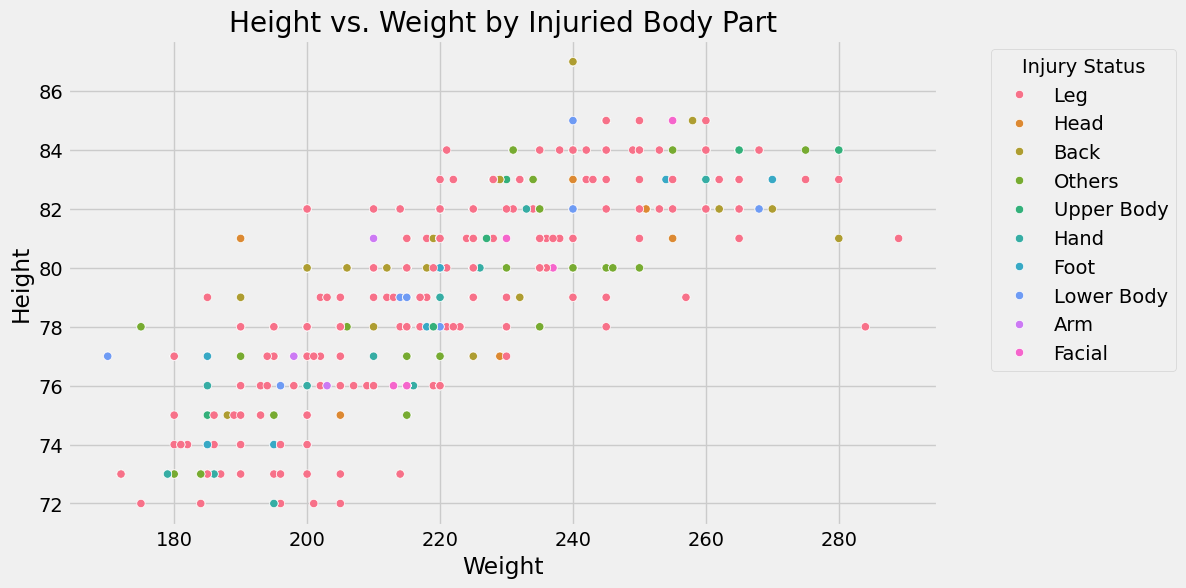

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PLAYER_WEIGHT', y='PLAYER_HEIGHT_INCHES', hue='body_part', data=merged_df_cleaned)
plt.title('Height vs. Weight by Injuried Body Part')
plt.xlabel('Weight')
plt.ylabel('Height')

plt.legend(title='Injury Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## No clear correlation. Overall, people with lower height and weight show less injuries over all but might be due to smaller sample size

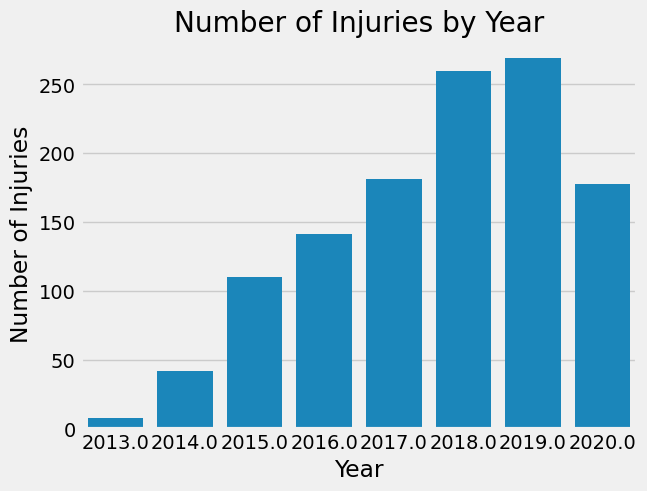

In [ ]:
# What year had the most injuries?

year_counts = merged_df_cleaned['year'].value_counts()
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries by Year')
plt.show()

# We can see clearly that the year with the most injuries was 2019, which had injuries more than 2010, 2011, and 2013 combined.

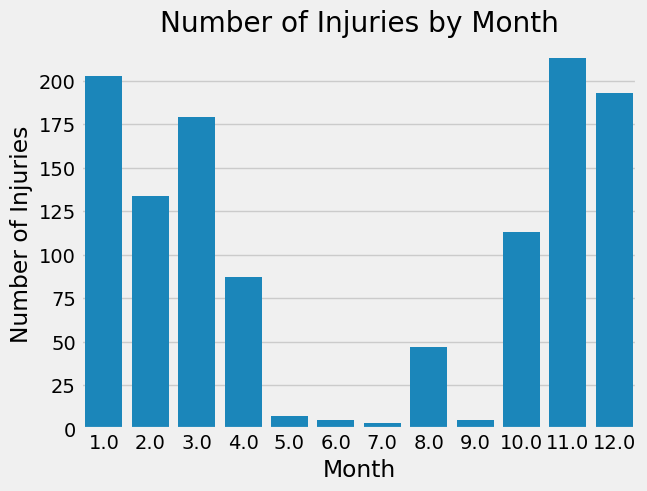

In [ ]:
# What months had the most injuries?

month_counts = merged_df_cleaned['month'].value_counts().sort_index()
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries by Month')
plt.show()

In [ ]:
# Perecentage of injuries that made the injured player go out indefinitely
# (meaning for a long period of time)

total_injuries = len(merged_df_cleaned[merged_df_cleaned['injury_type'].notna()])
out_indefinitely_count = merged_df_cleaned['Out Indefinitely'].sum()
percentage_out_indefinitely = (out_indefinitely_count / total_injuries) * 100

print(f"The percentage of injuries labeled as 'Out Indefinitely' is: {percentage_out_indefinitely:.2f}%")

The percentage of injuries labeled as 'Out Indefinitely' is: 12.28%


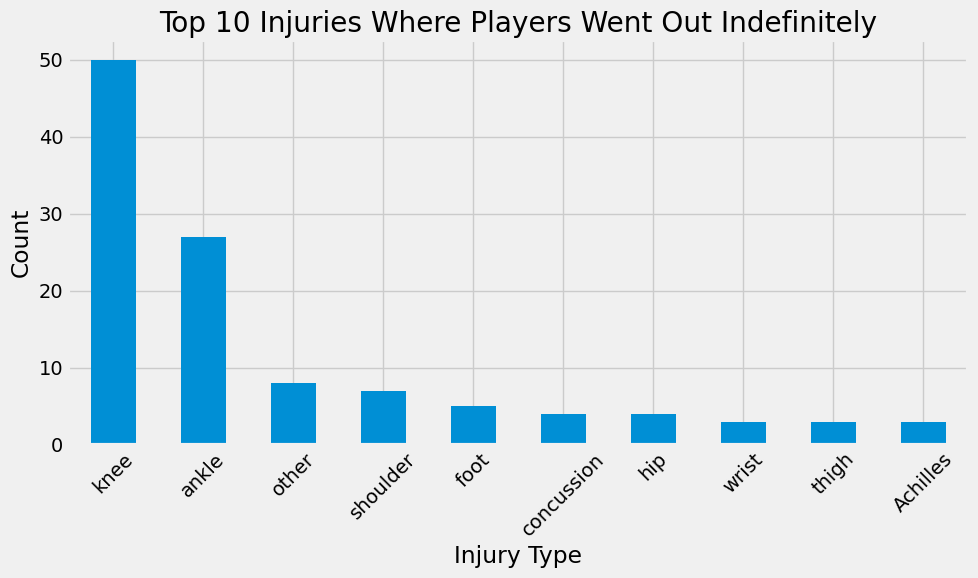

In [ ]:
# Top injuries where players went out indefinitely
indefinite_injuries = merged_df_cleaned[merged_df_cleaned['Out Indefinitely'] == True]
injury_counts = indefinite_injuries['injury_type'].value_counts()
plt.figure(figsize=(10, 6))
injury_counts.head(10).plot(kind='bar')
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.title('Top 10 Injuries Where Players Went Out Indefinitely')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# We can see that knee and ankle injuries where at the top of the list of
# injuries that made players go out indefinitely

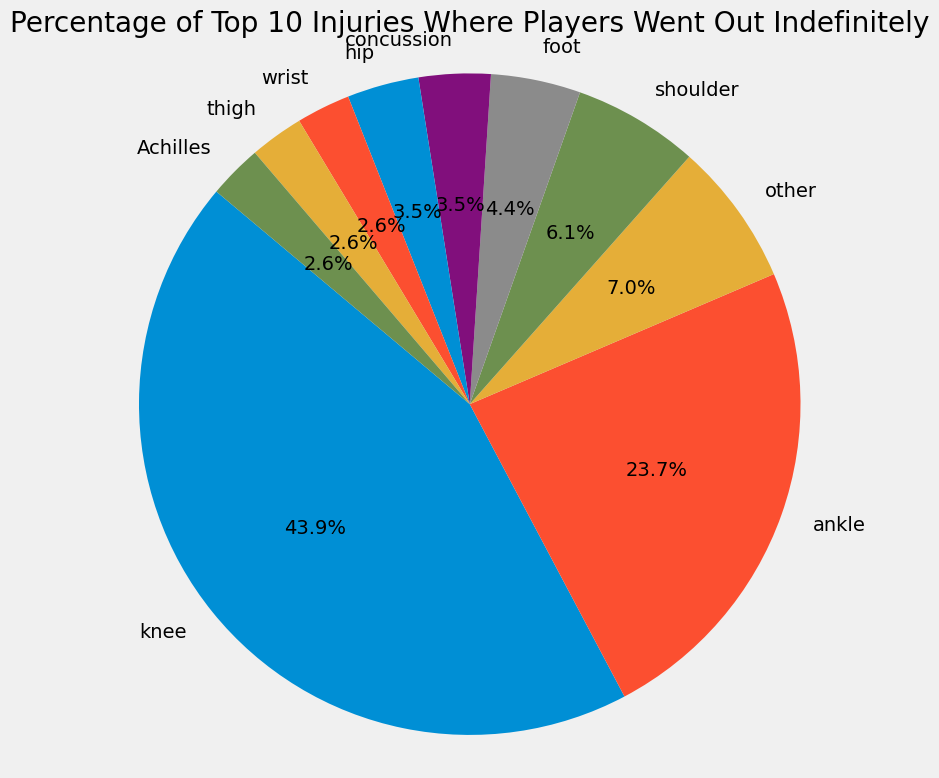

In [ ]:
# Percentage of injuries that were season ending
indefinite_injuries = merged_df_cleaned[merged_df_cleaned['Out Indefinitely'] == True]
injury_counts = indefinite_injuries['injury_type'].value_counts()
total_indefinite_injuries = injury_counts.sum()
percentage_per_injury = (injury_counts / total_indefinite_injuries) * 100
plt.figure(figsize=(8, 8))
plt.pie(percentage_per_injury.head(10), labels=percentage_per_injury.head(10).index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Top 10 Injuries Where Players Went Out Indefinitely')
plt.axis('equal')
plt.tight_layout()
plt.show()

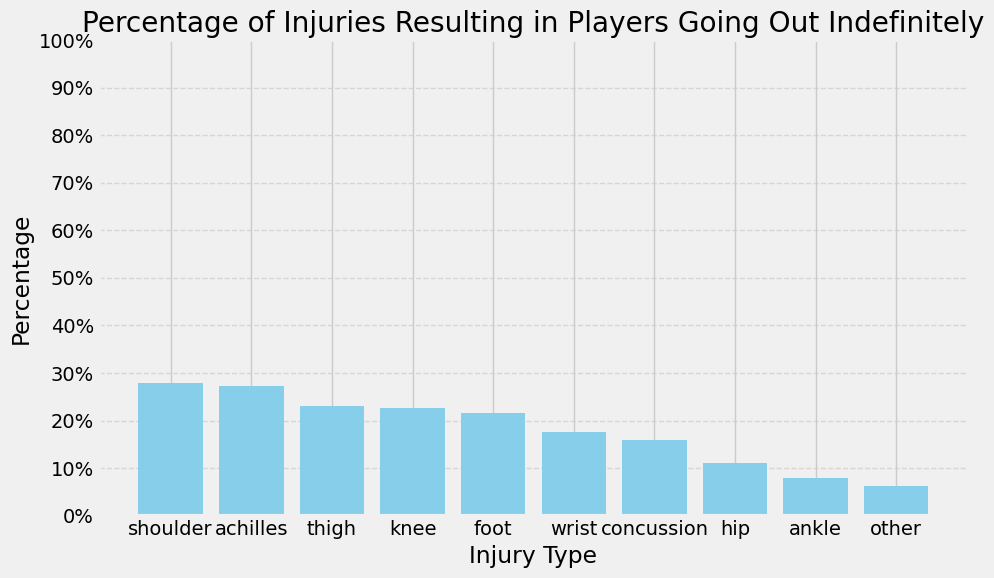

In [ ]:
# Percenate of Injuries in Players Going Out Indefinetly (BODY PART)
injuries_cleaned = merged_df_cleaned.dropna(subset=['injury_type'])

injury_types = ['knee', 'ankle', 'shoulder','foot', 'concussion','hip','wrist', 'thigh', 'achilles', 'other',]
injury_counts = {}
injury_indefinite_counts = {}

for injury_type in injury_types:
    current_injuries = injuries_cleaned[injuries_cleaned['injury_type'].str.contains(injury_type, case=False)]

    indefinite_injuries = current_injuries[current_injuries['Out Indefinitely'] == True]

    total_injuries = current_injuries.shape[0]
    indefinite_count = indefinite_injuries.shape[0]

    injury_counts[injury_type] = total_injuries
    injury_indefinite_counts[injury_type] = indefinite_count

percentages = {injury_type: (injury_indefinite_counts[injury_type] / injury_counts[injury_type]) * 100
               for injury_type in injury_types}
percentages = {k: v for k, v in sorted(percentages.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(10, 6))
plt.bar(percentages.keys(), percentages.values(), color='skyblue')
plt.xlabel('Injury Type')
plt.ylabel('Percentage')
plt.title('Percentage of Injuries Resulting in Players Going Out Indefinitely')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(0, 101, 10), [f'{i}%' for i in range(0, 101, 10)])
plt.tight_layout()
plt.show()

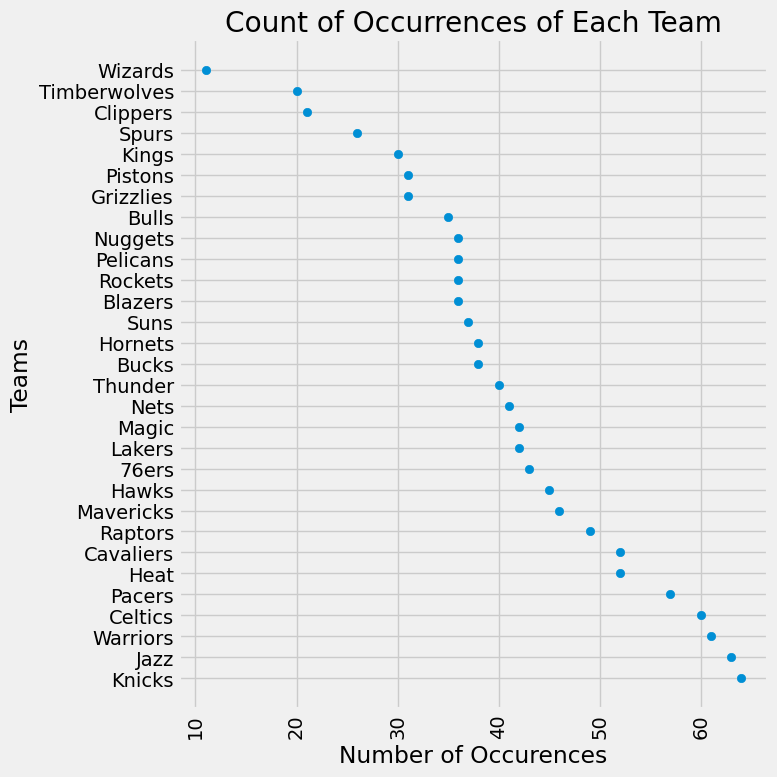

In [ ]:
# Count the occurrences of each team
team_counts = merged_df_cleaned['TEAM'].value_counts()

# Get the 30 most frequent teams
top_30_teams = team_counts.head(30)

# Extract team names and counts
teams = top_30_teams.values
counts = top_30_teams.index

# Plot the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(teams, counts)
plt.xlabel('Number of Occurences')
plt.ylabel('Teams')
plt.title('Count of Occurrences of Each Team')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# The graph below shows that the Knicks is the team with the highest number of injuries.

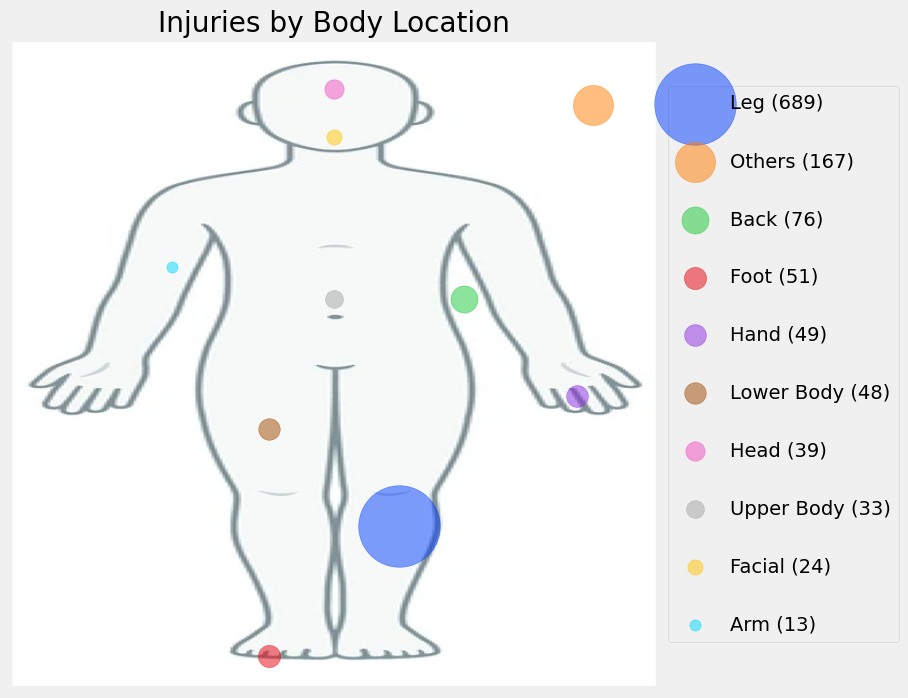

In [ ]:
from PIL import Image

counts = merged_df_cleaned['body_part'].value_counts()

body_img = Image.open('/content/gdrive/MyDrive/DSO 579 Sports Analytics/body_image.png')
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(body_img, extent=[0, 20, 0, 20])
bright_palette = sns.color_palette("bright")

for i, (injury, count) in enumerate(counts.items()):
    body_locations = {
        'Lower Body': (8, 8),
        'Leg': (12, 5),
        'Others': (18, 18),
        'Back': (14, 12),
        'Foot': (8, 1),
        'Hand': (17.5, 9),
        'Head': (10, 18.5),
        'Upper Body': (10, 12),
        'Facial': (10, 17),
        'Arm': (5, 13)
    }
    ax.scatter(*body_locations[injury], s=count*5, label=f'{injury} ({count})', alpha=0.5, color=bright_palette[i])


ax.set_title('Injuries by Body Location')
plt.xticks([])
plt.yticks([])

plt.xlabel('')
plt.ylabel('')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=2)
ax.set_aspect('equal')
plt.grid(False)
plt.show()


In [ ]:
merged_df.groupby('PLAYER_ID').agg({'GP': 'sum', 'body_part': 'count'}).sort_values(by = 'GP', ascending = False)

,GP,body_part
PLAYER_ID,,
201565,6367,122
2546,5845,94
203507,4485,56
201143,3851,52
203918,3812,61
...,...,...
1626296,1,0
1628769,1,0
1628935,1,0


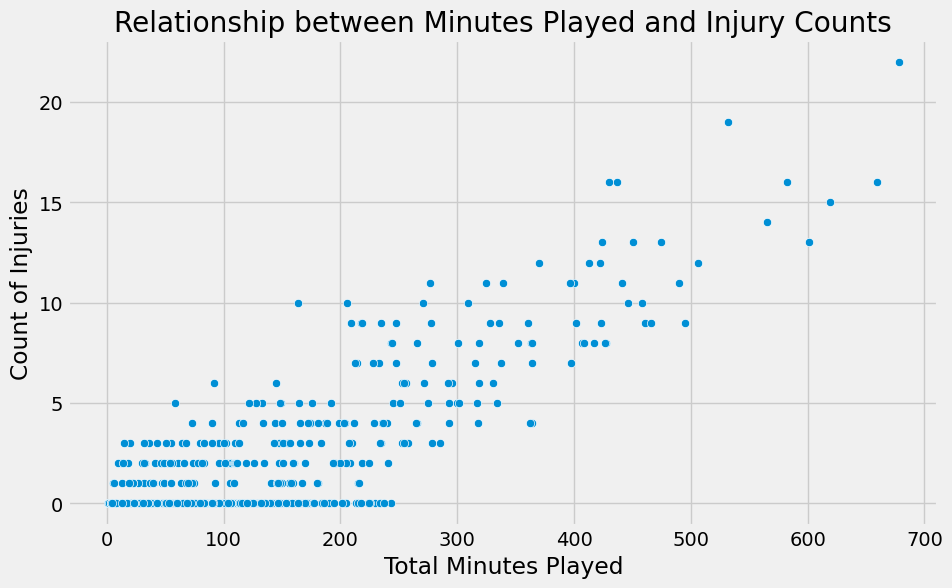

In [ ]:
total_injury = merged_df_cleaned.groupby('PLAYER_NAME')['body_part'].count().reset_index()
player_gp_counts = merged_df_cleaned.groupby(['PLAYER_NAME', 'SEASON'])['MIN'].sum().reset_index()
player_gp_counts = player_gp_counts.groupby('PLAYER_NAME')['MIN'].sum().reset_index()
player_stats = pd.merge(total_injury, player_gp_counts, on='PLAYER_NAME')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MIN', y='body_part', data=player_stats)
plt.title('Relationship between Minutes Played and Injury Counts')
plt.xlabel('Total Minutes Played')
plt.ylabel('Count of Injuries')
plt.show()

# This validate our assumption that the more games player are in they are more likely to get injuried

<ipython-input-46-2cd9893e0765>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = a.corr()


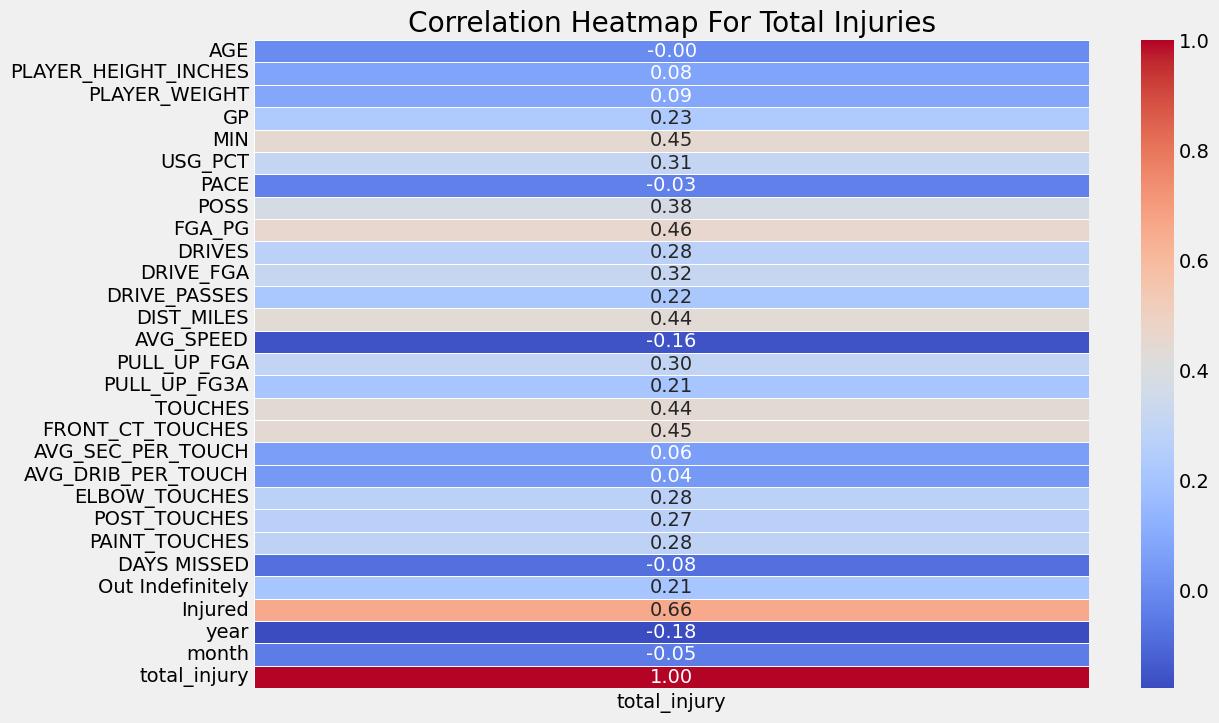

In [ ]:
a=merged_df_cleaned.copy()
a['total_injury'] = a.groupby('PLAYER_NAME')['body_part'].transform('count')
corr = a.corr()
corr = corr.drop(corr.columns[:-1], axis=1)
corr = corr.drop(['SEASON_NUM','lower body injury'], axis=0)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap For Total Injuries')
plt.show()

<Axes: >

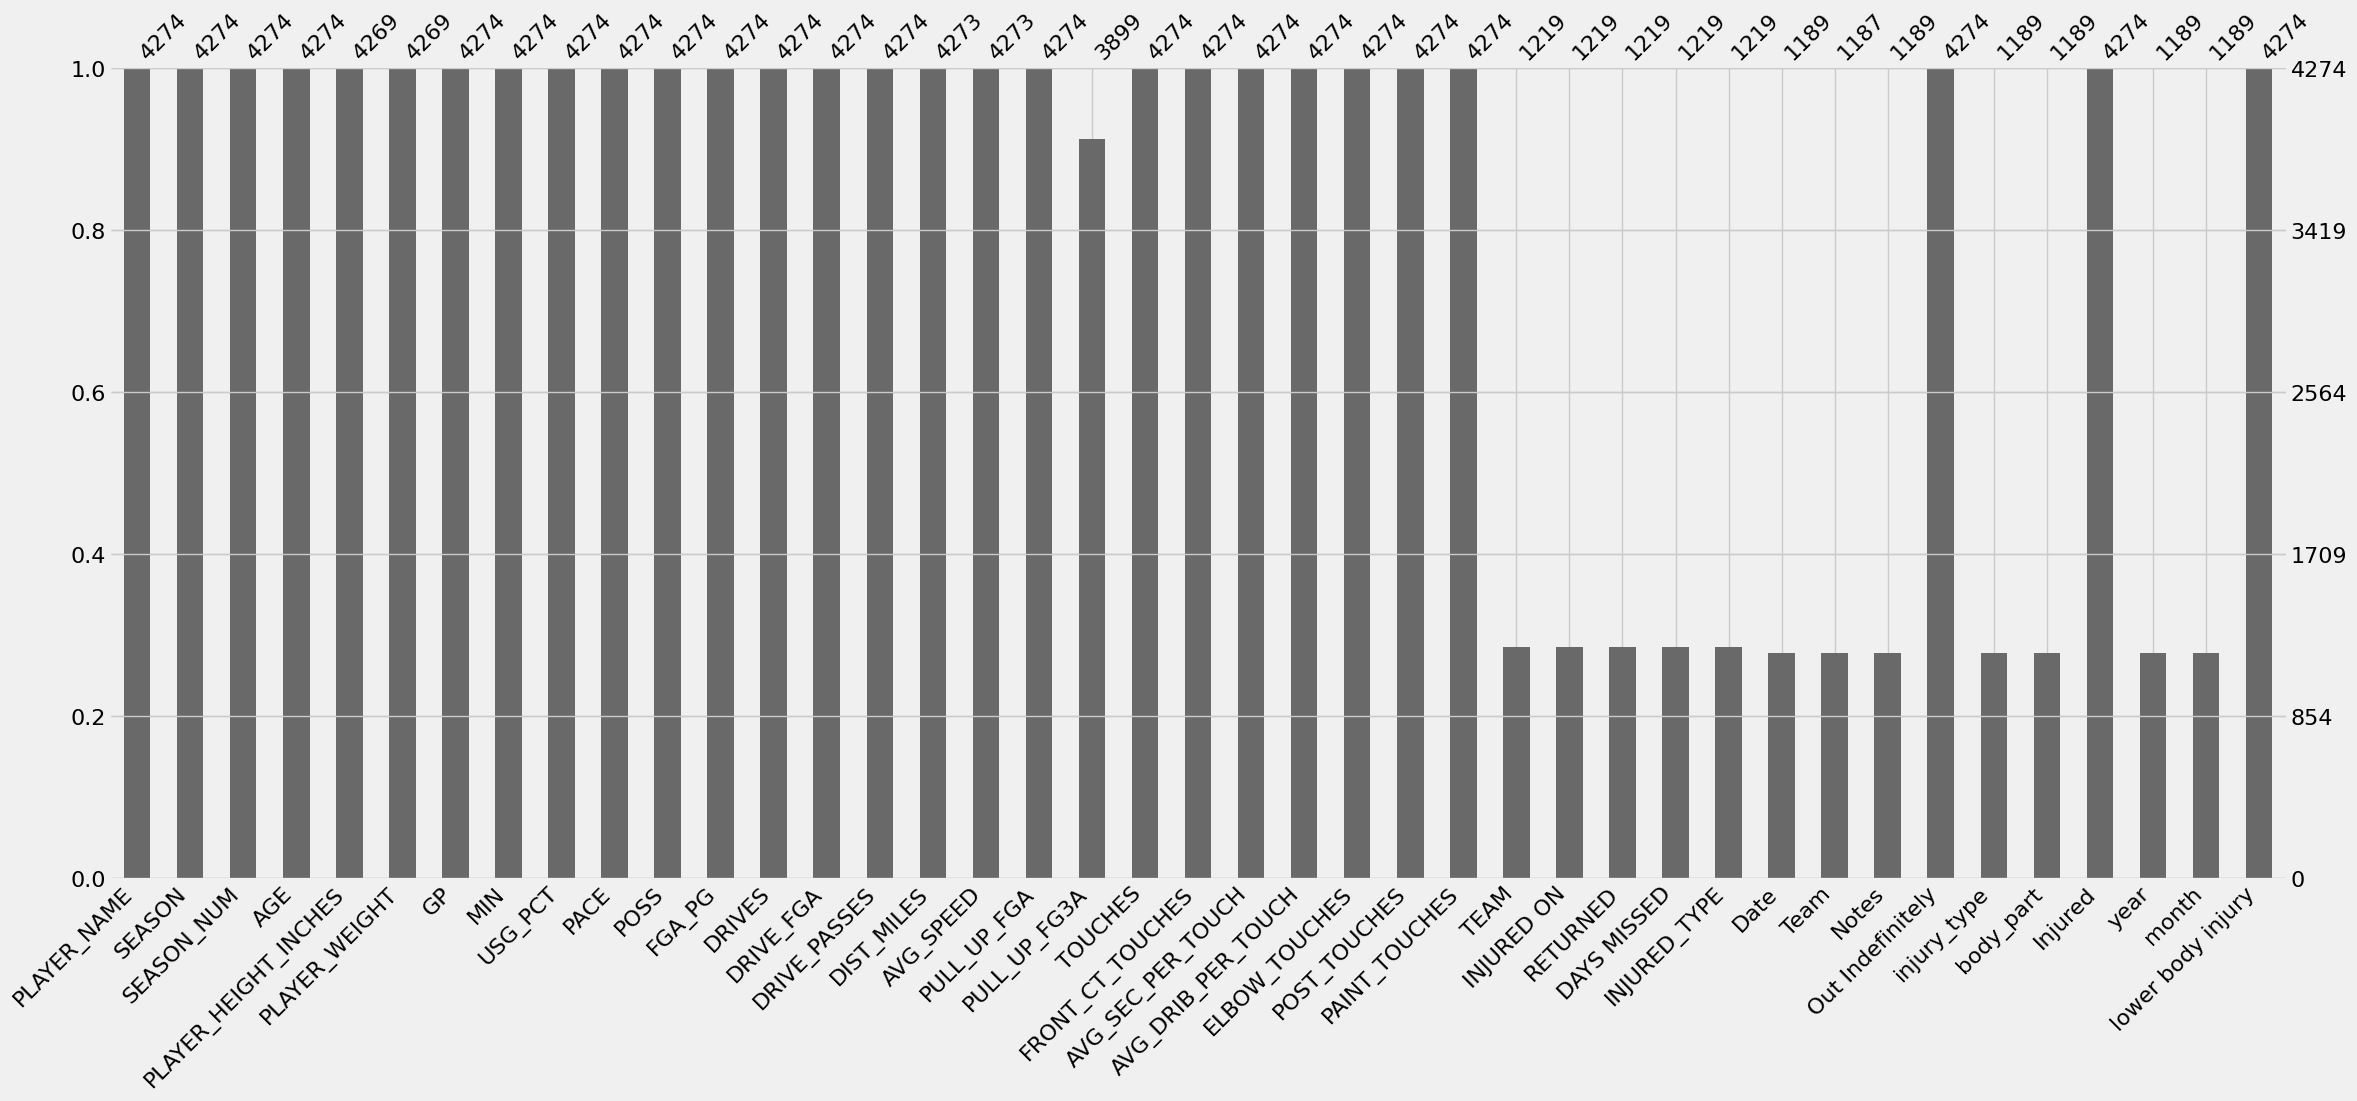

In [ ]:
import missingno as msno
msno.bar(merged_df_cleaned)

# 3. Model Building
Logistic, Decision Tree Classifier (with XGboosting, Random Forrest, Bagging)

## Logistic Regression

In [ ]:
na_counts = merged_df_cleaned.isna().sum()[merged_df_cleaned.isna().sum()> 0]
print(na_counts)

PLAYER_HEIGHT_INCHES       5
PLAYER_WEIGHT              5
DIST_MILES                 1
AVG_SPEED                  1
PULL_UP_FG3A             375
TEAM                    3055
INJURED ON              3055
RETURNED                3055
DAYS MISSED             3055
INJURED_TYPE            3055
Date                    3085
Team                    3087
Notes                   3085
injury_type             3085
body_part               3085
year                    3085
month                   3085
dtype: int64


In [ ]:
# deal with null values by imputing their values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
merged_df_cleaned[['PLAYER_WEIGHT', 'PLAYER_HEIGHT_INCHES','DIST_MILES','AVG_SPEED','PULL_UP_FG3A']] = imputer.fit_transform(merged_df_cleaned[['PLAYER_WEIGHT', 'PLAYER_HEIGHT_INCHES','DIST_MILES','AVG_SPEED','PULL_UP_FG3A']])

In [ ]:
y= merged_df_cleaned['Injured']
x= merged_df_cleaned.drop(columns = ['Injured','PLAYER_NAME', 'SEASON',
                                     'SEASON_NUM', 'TEAM', 'INJURED ON',
                                     'RETURNED', 'DAYS MISSED', 'INJURED_TYPE', 'Team',
                                     'Notes', 'Out Indefinitely', 'injury_type',
                                     'body_part', 'Date', 'year', 'month', 'lower body injury'] , axis=1)

X_train, X_test, Y_train, Y_test= \
train_test_split(x, y, test_size= 0.20, stratify=y)

In [ ]:
"""## Logistic Regression"""

logreg= LogisticRegression(random_state=0, max_iter=10000)

logreg.fit(X_train, Y_train)

Y_pred= logreg.predict(X_test)

logregScore= accuracy_score(Y_test, Y_pred)

print(f'Logistic Regression Score: {logregScore*100:.2f}%')

Logistic Regression Score: 75.67%


In [ ]:
import statsmodels.api as sm

# Add a constant to the predictor matrix for the intercept
X_train = sm.add_constant(X_train)

# Fit logistic regression model
logit_model = sm.Logit(Y_train, X_train)

# Obtain the results summary
logit_result = logit_model.fit()

# Print the summary
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.490133
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Injured   No. Observations:                 3419
Model:                          Logit   Df Residuals:                     3395
Method:                           MLE   Df Model:                           23
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                  0.1710
Time:                        21:00:34   Log-Likelihood:                -1675.8
converged:                       True   LL-Null:                       -2021.3
Covariance Type:            nonrobust   LLR p-value:                3.346e-131
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -18.8449      3.204     -5.882      0.000     -25.124     -12.566

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Print the VIF dataframe
print(vif_data)

                Variable          VIF
0                  const  4228.424967
1                    AGE     1.275258
2   PLAYER_HEIGHT_INCHES     4.781570
3          PLAYER_WEIGHT     4.010429
4                     GP     7.513771
5                    MIN   135.695436
6                USG_PCT     5.225250
7                   PACE     1.502521
8                   POSS    19.555322
9                 FGA_PG    39.386192
10                DRIVES   128.286493
11             DRIVE_FGA    44.423918
12          DRIVE_PASSES    33.472089
13            DIST_MILES   107.974159
14             AVG_SPEED     1.888746
15           PULL_UP_FGA    10.927638
16          PULL_UP_FG3A     3.678611
17               TOUCHES    12.579576
18      FRONT_CT_TOUCHES    14.913875
19     AVG_SEC_PER_TOUCH    61.243653
20    AVG_DRIB_PER_TOUCH    66.770975
21         ELBOW_TOUCHES     4.737830
22          POST_TOUCHES     4.064969
23         PAINT_TOUCHES     5.534194


### Feature Selection with Stepwise Method

In [ ]:
import statsmodels.api as sm

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Example usage:
y= merged_df_cleaned['Injured']
x= merged_df_cleaned.drop(columns = ['Injured','PLAYER_NAME', 'SEASON',
                                     'SEASON_NUM', 'TEAM', 'INJURED ON',
                                     'RETURNED', 'DAYS MISSED', 'INJURED_TYPE', 'Team',
                                     'Notes', 'Out Indefinitely', 'injury_type',
                                     'body_part', 'Date', 'year', 'month', 'lower body injury'] , axis=1)

result = stepwise_selection(x, y)

print('Resulting features:')
print(result)

<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DIST_MILES                     with p-value 1.94909e-108


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  PACE                           with p-value 1.6407e-21


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  PAINT_TOUCHES                  with p-value 1.02901e-14


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  AGE                            with p-value 6.77903e-05


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  POSS                           with p-value 0.000283739


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  AVG_SPEED                      with p-value 0.000125087


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  GP                             with p-value 5.34599e-06


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DRIVE_FGA                      with p-value 0.00557982


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  PLAYER_HEIGHT_INCHES           with p-value 0.000446131


<ipython-input-54-93160bd3b944>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Resulting features:
['DIST_MILES', 'PACE', 'PAINT_TOUCHES', 'AGE', 'POSS', 'AVG_SPEED', 'GP', 'DRIVE_FGA', 'PLAYER_HEIGHT_INCHES']


**Use the resulting Features to build our logistic model**

In [ ]:
stepwise_x = merged_df_cleaned[['DIST_MILES', 'PACE', 'PAINT_TOUCHES', 'AGE', 'POSS', 'AVG_SPEED', 'GP', 'DRIVE_FGA', 'PLAYER_HEIGHT_INCHES']]
y = merged_df_cleaned['Injured']

X_train1, X_test1, Y_train1, Y_test1= \
train_test_split(stepwise_x, y, test_size= 0.20, stratify=y)

In [ ]:
import statsmodels.api as sm

# Add a constant to the predictor matrix for the intercept
X_train_model = sm.add_constant(X_train1)

# Fit logistic regression model
logit_model1 = sm.Logit(Y_train1, X_train_model)

# Obtain the results summary
logit_result1 = logit_model1.fit()

# Print the summary
print(logit_result1.summary())

Optimization terminated successfully.
         Current function value: 0.494761
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Injured   No. Observations:                 3419
Model:                          Logit   Df Residuals:                     3409
Method:                           MLE   Df Model:                            9
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                  0.1631
Time:                        21:00:38   Log-Likelihood:                -1691.6
converged:                       True   LL-Null:                       -2021.3
Covariance Type:            nonrobust   LLR p-value:                3.598e-136
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -14.5443      2.159     -6.737      0.000     -18.776     -10.313

In [ ]:
"""## Logistic Regression"""

logreg= LogisticRegression(random_state=0, max_iter=1000)

logreg.fit(X_train1, Y_train1)

Y_pred1= logreg.predict(X_test1)

logregScore= accuracy_score(Y_test1, Y_pred1)

print(f'Logistic Regression Score: {logregScore*100:.2f}%')

Logistic Regression Score: 74.04%


In [ ]:
confusion_matrix(Y_pred1, Y_test1)

array([[563, 168],
       [ 54,  70]])

In [ ]:
accuracy = accuracy_score(Y_test1, Y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.7403508771929824


<Axes: >

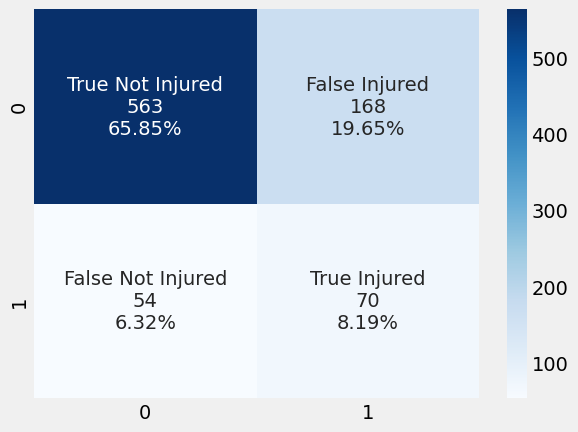

In [ ]:
group_names = ['True Not Injured','False Injured','False Not Injured','True Injured']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix(Y_pred1, Y_test1).flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix(Y_pred1, Y_test1).flatten()/np.sum(confusion_matrix(Y_pred1, Y_test1))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(Y_pred1, Y_test1), annot=labels, fmt='', cmap='Blues')

Precision: 0.5645161290322581
Recall: 0.29411764705882354
F1-score: 0.3867403314917127
ROC AUC: 0.6032986938697684


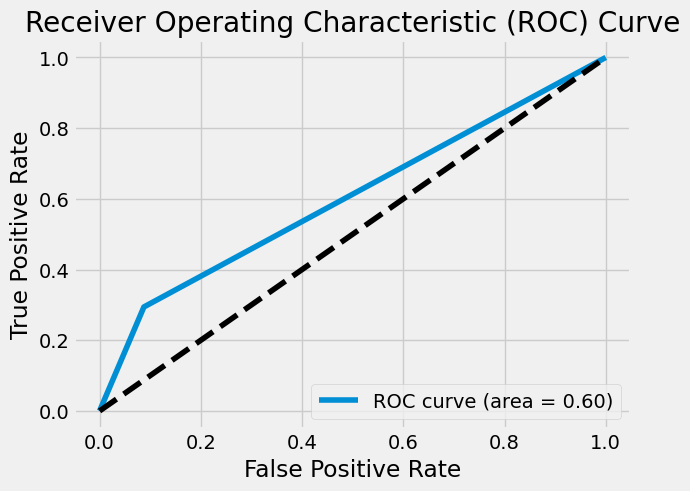

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

precision = precision_score(Y_test1, Y_pred1)
print("Precision:", precision)

recall = recall_score(Y_test1, Y_pred1)
print("Recall:", recall)

f1 = f1_score(Y_test1, Y_pred1)
print("F1-score:", f1)

roc_auc = roc_auc_score(Y_test1, Y_pred1)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(Y_test1, Y_pred1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
X_train.columns

Index(['const', 'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'GP', 'MIN',
       'USG_PCT', 'PACE', 'POSS', 'FGA_PG', 'DRIVES', 'DRIVE_FGA',
       'DRIVE_PASSES', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FGA',
       'PULL_UP_FG3A', 'TOUCHES', 'FRONT_CT_TOUCHES', 'AVG_SEC_PER_TOUCH',
       'AVG_DRIB_PER_TOUCH', 'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES'],
      dtype='object')

## Decision Tree Classifier (Bagging, Random Forest, XGBoosting ensembles)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best model score on test data: 0.7516786108756518


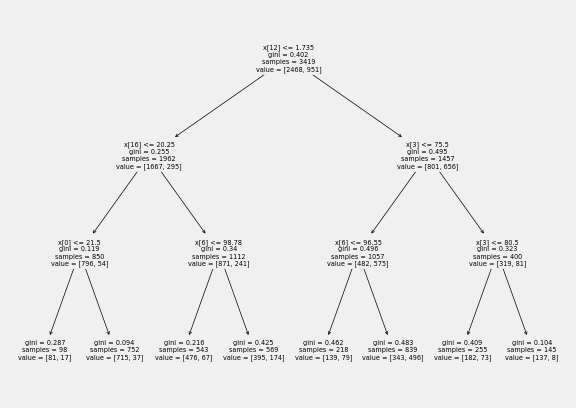

In [ ]:
# removing const from X_train for sklearn classifiers
# can only run once, otherwise will get error
X_train = X_train.drop('const', axis=1)

# instantiates model class
clf= DecisionTreeClassifier(random_state=42)

# dictionary with different hyperparameters for GridSearchCV to look through and
# find optimal params
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,3],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4]
}

# function that searches for optimal hyperparameters to optimize accuracy
gsTree= GridSearchCV(clf, param_grid=params, scoring='accuracy',
             cv=5)

gsTree.fit(X_train, Y_train)

bestParams= gsTree.best_params_
bestScore= gsTree.best_score_
bestModel= gsTree.best_estimator_

print(f"Best hyperparameters: {bestParams}")
print(f"Best model score on test data: {bestScore}")

# print out best tree

plot_tree(bestModel)
plt.show()

### Bagging Ensemble

In [ ]:
baggingClassifier = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)

# Fit the model to the training data
baggingClassifier.fit(X_train, Y_train)

# Evaluate the model on the test data
baggingScore = baggingClassifier.score(X_test, Y_test)

print(f"Bagging score on test data: {baggingScore*100:.2f}%")

Bagging score on test data: 93.92%


### XGBoost Ensemble

In [ ]:
xgbClassifier = XGBClassifier(random_state=42)

# Fit the model to the training data
xgbClassifier.fit(X_train, Y_train)

# Evaluate the model on the test data
xgbScore = xgbClassifier.score(X_test, Y_test)

print(f"XGBClassifier score on test data: {xgbScore*100:.2f}%")

XGBClassifier score on test data: 93.33%


In [ ]:
confusion_matrix(Y_test, xgbClassifier.predict(X_test))

array([[585,  32],
       [ 25, 213]])

### Random Forest Ensemble

In [ ]:
# Initializing the Random Forest classifier
rfClassifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model to the training data
rfClassifier.fit(X_train, Y_train)

# Evaluating the Random Forest model
yPred = rfClassifier.predict(X_test)
accuracyRF = accuracy_score(Y_test, Y_pred)
print(f"Random Forest model accuracy: {accuracyRF*100:.2f}%")

Random Forest model accuracy: 75.67%


### Model Comparison

In [ ]:
models = [
    {'model':'Base', 'score': bestScore},
    {'model': 'Bagging', 'score': baggingScore},
    {'model': 'XGBClassifier', 'score': xgbScore},
    {'model': 'Random Forest', 'score':accuracyRF}
]

# Create a DataFrame for the results
results_df = pd.DataFrame(models)

# Sort the DataFrame by score in descending order
results_df = results_df.sort_values(by='score', ascending=False)

# Print the results
print(results_df)

           model     score
1        Bagging  0.939181
2  XGBClassifier  0.933333
3  Random Forest  0.756725
0           Base  0.751679


### Confusion Matrix

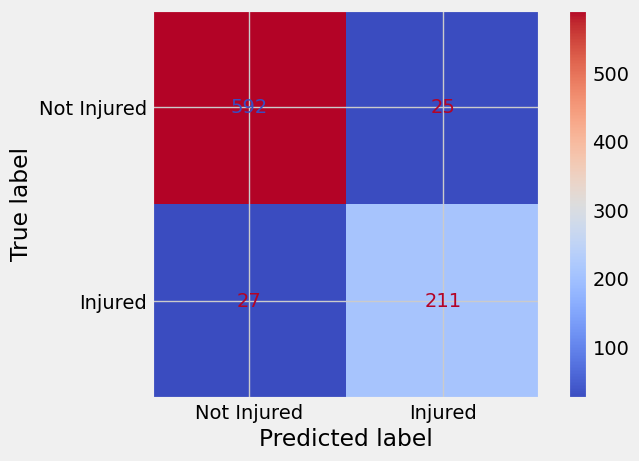

In [ ]:
Y_pred= baggingClassifier.predict(X_test)

cm= confusion_matrix(Y_test, Y_pred, labels=baggingClassifier.classes_)

class_labels= ['Not Injured', 'Injured']

display= ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_labels)
display.plot(cmap='coolwarm')
plt.show()